## Test two ways of computing $h^2$

### The variance should be conserved in a selected domain. The value for the selected domain should be the sum of the subdomains.

**SAH** (windowing & spectral) *vs* **JSL** (plane fit)

In [1]:
%matplotlib inline

import xrft
import math
import time
import scipy.io
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import matplotlib
from scipy import signal
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

from gsw import f
from matplotlib.colors import LogNorm
from scipy.fftpack import fft2, fftn, fftshift

import dask

import warnings
warnings.filterwarnings('ignore')

In [2]:
def windowing(topog_sample, alpha=0.8, border=0.9):

    # shape parameter of the Tukey window (flat + cosine tapered region)
    # - raidus < alpha, factor = 1
    # - alpha < radius < alpha, factor decays from 1 to 0
    # - radius > border, factor = 0
    
    vari = np.var(topog_sample)

    ydim, xdim = topog_sample.dims
    nx = topog_sample[xdim].size
    ny = topog_sample[ydim].size

    # Create coordinate grid
    x = np.linspace(-1, 1, nx)
    y = np.linspace(-1, 1, ny)
    xv, yv = np.meshgrid(x, y)
    
    # Calculate radial distance from the center
    r = np.sqrt(xv**2 + yv**2)
    
    # Initialize the window with zeros
    window = np.zeros((nx, ny))
    
    # Apply Tukey window formula
    for i in range(nx):
        for j in range(ny):
            if r[i, j] <= alpha:
                window[i, j] = 1
            elif r[i, j] <= border:
                window[i, j] = 0.5*(1 + np.cos( np.pi * (r[i, j] - alpha ) / (border - alpha) ))
            else:
                window[i, j] = 0

    topog_filt = topog_sample * window
    varf = np.var(topog_filt)
    fac  = np.sqrt(vari/varf).values
    window *= fac
    topog_filt *= fac
    # print('Window max, min = ', np.nanmax(window), np.nanmin(window))
    # print('The factor multiplied to conserve the variance is: ', fac)
    return topog_filt, window, fac

In [3]:
def fft_topog(topog,delta_lon,delta_lat,alpha=0.8,border=0.9,k_grid_units=True):

    ydim, xdim = topog.dims
    nx = topog[xdim].size
    ny = topog[ydim].size
    dx = np.mean(np.diff(topog[xdim]))*delta_lon*1e+3
    dy = np.mean(np.diff(topog[ydim]))*delta_lat*1e+3

    # demean
    topog -= topog.mean(skipna=True) 

    # windowing
    topog_filt, window, fac = windowing(topog,alpha=0.8,border=0.9)

    # FFT
    topog_fft = fft2(topog_filt.values)
    topog_spd = (topog_fft*topog_fft.conjugate()).real
    topog_spd[0,0] = np.nan          # nan at removed zero frequency
    topog_spd = fftshift(topog_spd)  # put zero wavenumber in array centre
    topog_spd *= dx*dy

    if (k_grid_units):
        # k in units cycles/dx:
        topog_spd = xr.DataArray(topog_spd, dims=['ky','kx'], 
                                 coords={'ky': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny), 
                                         'kx': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)},
                                 attrs={'long_name': 'wavenumber spectrum in grid units'})
        topog_spd.kx.attrs['units'] = 'cycles/dx'
        topog_spd.ky.attrs['units'] = 'cycles/dy'
        topog_spd.kx.attrs['long_name'] = 'x wavenumber'
        topog_spd.ky.attrs['long_name'] = 'y wavenumber'

        # No rescaling

    else:
        # k in units cycles/(units of dx)
        topog_spd = xr.DataArray(topog_spd, dims=['ky','kx'], 
                                 coords={'ky': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny)*(2*np.pi/dy),
                                         'kx': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)*(2*np.pi/dx)},
                                 attrs={'long_name': 'wavenumber spectrum in grid units'})
        topog_spd.kx.attrs['units'] = 'radians/meters'
        topog_spd.ky.attrs['units'] = 'radians/meters'
        topog_spd.kx.attrs['long_name'] = 'x wavenumber'
        topog_spd.ky.attrs['long_name'] = 'y wavenumber'

        # Rescale to satisfy Parseval's theorem:
        topog_spd /= 4*np.pi**2./dx/dy

    return topog_spd, topog_filt, dx, dy, window, fac

In [4]:
def get_delta(lat):

    # compute the distance in km at this lon and lat
    delta_lon = 2 * np.pi * (6371 * np.cos(lat*np.pi/180)) / 360
    delta_lat = 1 * np.pi * 6371 / 180
    
    return delta_lon, delta_lat

In [5]:
def compute_h_rms(A,topog_spd_2d):

    const = 1 / (4 * A * np.pi**2)
    kx_2D, ky_2D = np.meshgrid(topog_spd_2d.kx,topog_spd_2d.ky,indexing='xy')
    dkx, dky = np.max(np.diff(topog_spd_2d.kx)), np.max(np.diff(topog_spd_2d.ky))
    int_kl = topog_spd_2d * dkx * dky
    h_rms = np.sqrt(const * np.nansum(int_kl[:]))

    return h_rms

In [6]:
def my_floor(a, precision=2):
    return np.round(a - 0.5 * 10**(-precision), precision)

In [7]:
# select a domain, 10 deg by 10 deg
topog = xr.open_dataset('/g/data/nm03/lxy581/synbath/SYNBATH.nc')
topog_sample = topog.z[240*135:240*145,240*145:240*155]

ydim, xdim = topog_sample.dims
nx = topog_sample[xdim].size
ny = topog_sample[ydim].size

lon = topog_sample.lon
lat = topog_sample.lat

yind = 240*140-1
xind = 240*150-1
print('Location for the centre point: \nLon: %.1f W;' % np.abs(topog.lon[xind].values),'\nLat: %.1f N.' % topog.lat[yind].values)

Location for the centre point: 
Lon: 30.0 W; 
Lat: 50.0 N.


### Spectral analysis (including demean and windowing)

In [8]:
lat = 50
delta_lon, delta_lat = get_delta(lat)
topog_spd_2d, topog_filt, dx, dy, window, fac = fft_topog(topog_sample,delta_lon,delta_lat,alpha=0.8,border=0.9,k_grid_units=False)

### Filter the topography and keep in only in the center of the domain (flat edges)

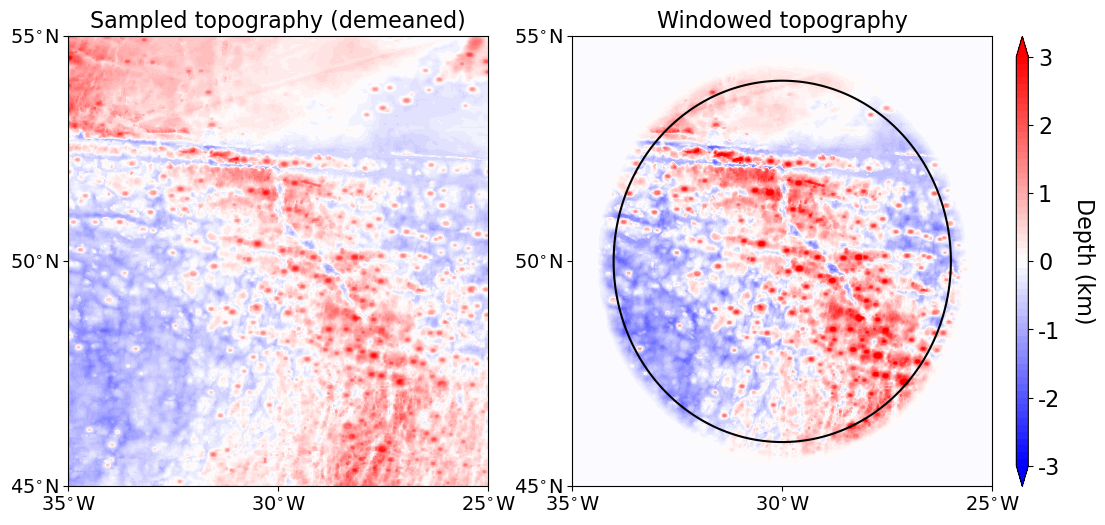

In [9]:
varlist = ['topog_sample','topog_filt']
title   = ['Sampled topography (demeaned)', 'Windowed topography']
levels  = np.arange(-3000,3000+100,100)

fig = plt.figure(figsize=(12, 6))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    p = ax.contourf(globals()[var], levels=levels, cmap='bwr', vmin=-3000, vmax=3000, extend="both") 

    if I==1:
        ax.contour(window, levels=np.array([my_floor(fac)]), colors='k')

    ax.set_title(title[I],fontsize=16)
    ax.set_xticks(np.arange(0,240*10+240*5,240*5))
    ax.set_yticks(np.arange(0,240*10+240*5,240*5))
    # xlabels = np.array([np.round(topog.lon[240*145].values), 
    #                    np.round(topog.lon[240*150].values), 
    #                    np.round(topog.lon[240*155].values)])
    # ylabels = np.array([np.round(topog.lat[240*135].values), 
    #                    np.round(topog.lat[240*140].values), 
    #                    np.round(topog.lat[240*145].values)])
    ax.set_xticklabels(['35$^{\circ}$W','30$^{\circ}$W','25$^{\circ}$W'],fontsize=14)
    ax.set_yticklabels(['45$^{\circ}$N','50$^{\circ}$N','55$^{\circ}$N'],fontsize=14)
    
    if I==0:
        ax.set_position([0.1,0.1,0.35,0.75])
    if I==1:
        ax.set_position([0.52,0.1,0.35,0.75])

    tick_locs = np.arange(-3000,3000+1000,1000)
    tick_labels = np.array(['-3','-2','-1','0','1','2','3'])
    
    if I==1:
        ax_cb = plt.axes([0.89, 0.1, 0.01, 0.75])  
        cb = plt.colorbar(p, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.set_ylabel('Depth (km)',fontsize=16,rotation=270,labelpad=25);
        cb.ax.tick_params(labelsize=16)
        cb.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

### Test if the window conserves the variance

In [10]:
topog_variance = np.var(topog_sample)
topog_filt_variance = np.var(topog_filt)
A_loc = 10 * delta_lon * 1e+3 * 10 * delta_lat * 1e+3 
print('Variance for the entire domain before windowing: % 3.2e' % (topog_variance.values * A_loc))
print('Variance for the entire domain after windowing: % 3.2e' % (topog_filt_variance.values * A_loc))

Variance for the entire domain before windowing:  2.83e+17
Variance for the entire domain after windowing:  2.83e+17


### check Parseval's theorem

In [11]:
print('Checking Parsevals theorem...')
dkx, dky = np.max(np.diff(topog_spd_2d.kx)), np.max(np.diff(topog_spd_2d.ky))
fft2dsum = topog_spd_2d.sum().sum()*dkx*dky
print('2D sum (k-space) = %3.2e' % fft2dsum)
var_int_x = np.nansum(topog_filt **2 * dy * dx)
print('2D sum (x-space) = %3.2e' % var_int_x)

Checking Parsevals theorem...
2D sum (k-space) = 2.83e+17
2D sum (x-space) = 2.84e+17


### Compute $h^2$ for the entire domain

In [12]:
A_loc = 10 * delta_lon * 1e+3 * 10 * delta_lat * 1e+3 
h_rms = compute_h_rms(A_loc,topog_spd_2d)
var_int_k = h_rms**2 * 4 * A_loc * np.pi**2
print('rms height = %.2f m' % h_rms)
print('h_rms^2 * 4 * A * np.pi**2 = %3.2e' % var_int_k)

rms height = 95.03 m
h_rms^2 * 4 * A * np.pi**2 = 2.83e+17


### Compute $h^2$ for 3 by 3 small domains (4 tiles)

#### Locate the centre points for 4 tiles

In [13]:
ny, nx = topog_sample.shape
var_win_shift = ['window_shift_bl','window_shift_br',
                 'window_shift_tl','window_shift_tr']

for var in var_win_shift:
    globals()[var] = np.zeros((ny,nx))

In [14]:
# bottom left 
topog_tile_bl = topog_sample[0:int(ny/2),0:int(nx/2)]

# bottom right
topog_tile_br = topog_sample[0:int(ny/2),int(nx/2):]

# top left 
topog_tile_tl = topog_sample[int(ny/2):,0:int(nx/2)]

# top right
topog_tile_tr = topog_sample[int(ny/2):,int(nx/2):]

In [15]:
var_topog_tile = ['topog_tile_bl','topog_tile_br',
                  'topog_tile_tl','topog_tile_tr']

var_topog_filt = ['topog_filt_bl','topog_filt_br',
                  'topog_filt_tl','topog_filt_tr']

var_topog_spec = ['topog_spec_bl','topog_spec_br',
                  'topog_spec_tl','topog_spec_tr']

var_hrms_spec = ['topog_hrms_bl','topog_hrms_br',
                 'topog_hrms_tl','topog_hrms_tr']

var_window = ['window_bl','window_br',
              'window_tl','window_tr']

var_factor = ['fac_bl','fac_br',
              'fac_tl','fac_tr']

In [16]:
for var_spec, var_filt, var_tile, var_win, var_fac in zip(var_topog_spec, var_topog_filt, var_topog_tile, var_window, var_factor):
    globals()[var_spec], globals()[var_filt], dx, dy, globals()[var_win], globals()[var_fac] = fft_topog(globals()[var_tile],delta_lon,delta_lat,alpha=0.8,border=0.9,k_grid_units=False)

In [17]:
window_shift_bl[0:int(ny/2),0:int(nx/2)] = window_bl
window_shift_br[0:int(ny/2),int(nx/2):] = window_br

window_shift_tl[int(ny/2):,0:int(nx/2)] = window_tl
window_shift_tr[int(ny/2):,int(nx/2):] = window_tr

In [18]:
topog_filt_shift = np.zeros((ny,nx))

topog_filt_shift[0:int(ny/2),0:int(nx/2)] = topog_filt_bl
topog_filt_shift[0:int(ny/2),int(nx/2):] = topog_filt_br

topog_filt_shift[int(ny/2):,0:int(nx/2)] = topog_filt_tl
topog_filt_shift[int(ny/2):,int(nx/2):] = topog_filt_tr

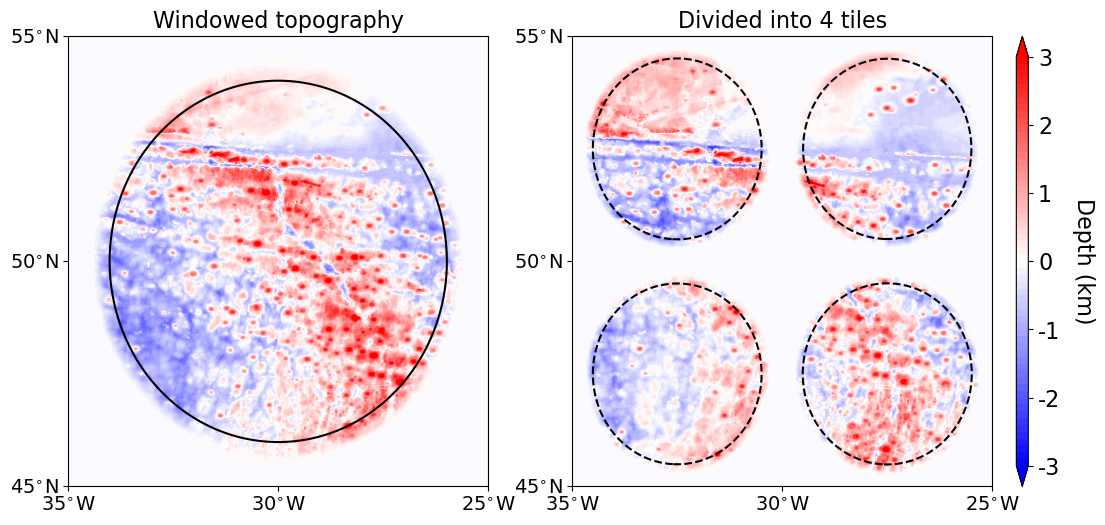

In [19]:
varlist = ['topog_filt','topog_filt']

fac_win = [my_floor(fac_bl),my_floor(fac_br),
           my_floor(fac_tl),my_floor(fac_tr)]

title   = ['Windowed topography', 'Divided into 4 tiles']
levels  = np.arange(-3000,3000+100,100)

fig = plt.figure(figsize=(12, 6))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    if I==0:
        p = ax.contourf(globals()[var], levels=levels, cmap='bwr', vmin=-3000, vmax=3000, extend="both") 
        ax.contour(window, levels=np.array([my_floor(fac)]), colors='k') 

    if I==1:
        ax.contourf(topog_filt_shift, levels=levels, cmap='bwr', vmin=-3000, vmax=3000, extend="both")
        
        for var2, level in zip(var_win_shift, fac_win):
            ax.contour(globals()[var2], levels=[level], colors='k',linestyles='dashed')

    ax.set_title(title[I],fontsize=16)
    ax.set_xticks(np.arange(0,240*10+240*5,240*5))
    ax.set_yticks(np.arange(0,240*10+240*5,240*5))
    ax.set_xticklabels(['35$^{\circ}$W','30$^{\circ}$W','25$^{\circ}$W'],fontsize=14)
    ax.set_yticklabels(['45$^{\circ}$N','50$^{\circ}$N','55$^{\circ}$N'],fontsize=14)
    
    if I==0:
        ax.set_position([0.1,0.1,0.35,0.75])
    if I==1:
        ax.set_position([0.52,0.1,0.35,0.75])

    tick_locs = np.arange(-3000,3000+1000,1000)
    tick_labels = np.array(['-3','-2','-1','0','1','2','3'])
    
    if I==1:
        ax_cb = plt.axes([0.89, 0.1, 0.01, 0.75])  
        cb = plt.colorbar(p, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.set_ylabel('Depth (km)',fontsize=16,rotation=270,labelpad=25);
        cb.ax.tick_params(labelsize=16)
        cb.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

### Check the variance for each tile before and after windowing

In [20]:
A_loc = 5 * delta_lon * 1e+3 * 5 * delta_lat * 1e+3

for var_tile, var_filt in zip(var_topog_tile, var_topog_filt):
    print('Variance before windowing: %3.2e '% (np.var(globals()[var_tile]).values * A_loc))
    print('Variance after windowing: %3.2e \n'% (np.var(globals()[var_filt]).values * A_loc))

Variance before windowing: 3.69e+16 
Variance after windowing: 3.69e+16 

Variance before windowing: 5.50e+16 
Variance after windowing: 5.50e+16 

Variance before windowing: 6.87e+16 
Variance after windowing: 6.87e+16 

Variance before windowing: 3.52e+16 
Variance after windowing: 3.52e+16 



### Spectral analysis for each tile

In [21]:
A_loc = 5 * delta_lon * 1e+3 * 5 * delta_lat * 1e+3
total = 0

for var_spec, var_filt, var_hrms in zip(var_topog_spec, var_topog_filt, var_hrms_spec):
    globals()[var_hrms] = compute_h_rms(A_loc,globals()[var_spec])
    print('rms height = %.2f m' % globals()[var_hrms])
    print('Checking Parsevals theorem: ')
    dkx, dky = np.max(np.diff(globals()[var_spec].kx)), np.max(np.diff(globals()[var_spec].ky))
    fft2dsum = globals()[var_spec].sum().sum()*dkx*dky
    print('2D sum (k-space) = %3.2e' % fft2dsum)
    var_int_x = np.nansum(globals()[var_filt] **2 * dy * dx)
    print('2D sum (x-space) = %3.2e \n' % var_int_x)
    total = total + globals()[var_hrms]**2 * 4 * A_loc * np.pi**2

print('Sum of variance: ', total)

rms height = 68.61 m
Checking Parsevals theorem: 
2D sum (k-space) = 3.69e+16
2D sum (x-space) = 3.80e+16 

rms height = 83.74 m
Checking Parsevals theorem: 
2D sum (k-space) = 5.50e+16
2D sum (x-space) = 5.67e+16 

rms height = 93.55 m
Checking Parsevals theorem: 
2D sum (k-space) = 6.87e+16
2D sum (x-space) = 6.88e+16 

rms height = 66.98 m
Checking Parsevals theorem: 
2D sum (k-space) = 3.52e+16
2D sum (x-space) = 3.69e+16 

Sum of variance:  1.9578202980353142e+17


#### Hrms for the entire domain was 95.03 m 

#### Variance for the entire domain was 2.83e+17

### Reconstruct the sampled topography from demeaned tiles

In [22]:
topog_tile_bl -= np.nanmean(topog_tile_bl)
topog_tile_br -= np.nanmean(topog_tile_br)
topog_tile_tl -= np.nanmean(topog_tile_tl)
topog_tile_tr -= np.nanmean(topog_tile_tr)

In [23]:
topog_sample_re = np.zeros((ny,nx))

topog_sample_re[0:int(ny/2),0:int(nx/2)] = topog_tile_bl
topog_sample_re[0:int(ny/2),int(nx/2):] = topog_tile_br 
topog_sample_re[int(ny/2):,0:int(nx/2)] = topog_tile_tl 
topog_sample_re[int(ny/2):,int(nx/2):] = topog_tile_tr 

In [24]:
print(np.nanmean(topog_sample_re))

-2.0356487275825605e-05


In [25]:
topog_var_re = np.var(topog_sample_re)

A_loc = 10 * delta_lon * 1e+3 * 10 * delta_lat * 1e+3 
print('Variance for the entire domain before windowing: % 3.2e' % (topog_var_re * A_loc))

Variance for the entire domain before windowing:  1.96e+17


In [27]:
topog_sample

<xarray.DataArray 'z' (lat: 2400, lon: 2400)> Size: 23MB
array([[-559.8242 , -562.49756, -565.64307, ...,  462.71335,  499.31345,
         511.80197],
       [-559.03613, -560.06104, -561.06104, ...,  470.57468,  506.69504,
         513.45605],
       [-562.68066, -563.06104, -557.06104, ...,  459.1362 ,  479.74142,
         493.0024 ],
       ...,
       [ 998.0426 , 1012.1903 , 1051.4183 , ...,  276.26358,  278.49454,
         278.4113 ],
       [1008.2665 , 1005.525  , 1053.4843 , ...,  287.33926,  290.3544 ,
         288.67642],
       [1047.6915 , 1042.151  , 1056.2277 , ...,  295.21085,  297.45206,
         295.87393]], dtype=float32)
Coordinates:
  * lon      (lon) float64 19kB -35.0 -34.99 -34.99 ... -25.01 -25.01 -25.0
  * lat      (lat) float64 19kB 45.0 45.01 45.01 45.01 ... 54.99 54.99 55.0
Attributes:
    long_name:     z
    actual_range:  [-11058.   8627.]

In [28]:
topog_sample_re_xr = xr.DataArray(topog_sample_re, dims=['lat','lon'], 
                                  coords={'lon': topog_sample.lon, 
                                          'lat': topog_sample.lat},
                                  attrs={'long_name': 'reconstructed sampled topography'})

In [30]:
topog_spd_2d_re, topog_filt_re, dx, dy, window_re, fac_re = fft_topog(topog_sample_re_xr,delta_lon,delta_lat,alpha=0.8,border=0.9,k_grid_units=False)

#### Test if the window conserves the variance

In [32]:
topog_variance = np.var(topog_sample_re)
topog_filt_variance = np.var(topog_filt_re)
A_loc = 10 * delta_lon * 1e+3 * 10 * delta_lat * 1e+3 
print('Variance for the entire domain before windowing: % 3.2e' % (topog_variance * A_loc))
print('Variance for the entire domain after windowing: % 3.2e' % (topog_filt_variance.values * A_loc))

Variance for the entire domain before windowing:  1.96e+17
Variance for the entire domain after windowing:  1.96e+17


### check Parseval's theorem

In [33]:
print('Checking Parsevals theorem...')
dkx, dky = np.max(np.diff(topog_spd_2d_re.kx)), np.max(np.diff(topog_spd_2d_re.ky))
fft2dsum = topog_spd_2d_re.sum().sum()*dkx*dky
print('2D sum (k-space) = %3.2e' % fft2dsum)
var_int_x = np.nansum(topog_filt_re **2 * dy * dx)
print('2D sum (x-space) = %3.2e' % var_int_x)

Checking Parsevals theorem...
2D sum (k-space) = 1.96e+17
2D sum (x-space) = 1.96e+17


### Compute $h^2$ for the entire domain

In [35]:
A_loc = 10 * delta_lon * 1e+3 * 10 * delta_lat * 1e+3 
h_rms_re = compute_h_rms(A_loc,topog_spd_2d_re)
var_int_k = h_rms_re**2 * 4 * A_loc * np.pi**2
print('rms height = %.2f m' % h_rms_re)
print('h_rms^2 * 4 * A * np.pi**2 = %3.2e' % var_int_k)

rms height = 79.03 m
h_rms^2 * 4 * A * np.pi**2 = 1.96e+17
